# EM-APEX floats in TIWs

Test out deployment strategies using OceanParcels

Todo:
- [ ] check that grid is right given Scott's subsampling
- [ ] slow down particles 10m below surface and 10m above maxdepth

In [ ]:
%matplotlib inline
%load_ext watermark

from datetime import timedelta

import cf_xarray
import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.units as munits
import numpy as np
import pandas as pd
import parcels
import xarray as xr
from parcels import (
    AdvectionRK4,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    StateCode,
    Variable,
)

import pump

%watermark -iv

INFO: Compiled ParcelsRandom ==> /glade/scratch/dcherian/tmp/parcels-25721/libparcels_random_e8684722-16b7-49c5-ab13-5ee6e4cc1801.so


pandas     : 1.1.3
xarray     : 0.16.3.dev150+g37522e991
dcpy       : 0.1
numpy      : 1.19.2
parcels    : 2.2.2
distributed: 2.30.0
pump       : 0.1
matplotlib : 3.3.2
cf_xarray  : 0.4.1.dev31+g7a8c620
dask       : 2.30.0



In [ ]:
ds = xr.open_dataset("/glade/campaign/cgd/oce/people/dcherian/TPOS_MITgcm_1_hb/full_domain/HOLD_NC/Day_2000.nc")

In [ ]:
dirname = "/glade/campaign/cgd/oce/people/dcherian/TPOS_MITgcm_1_hb/tiw"
filenames = dict.fromkeys(("U", "V", "temp", "salt"), f"{dirname}/File*buoy.nc")

dirname = (
    "/glade/campaign/cgd/oce/people/dcherian/TPOS_MITgcm_1_hb/full_domain/HOLD_NC/"
)
filenames = dict.fromkeys(("U", "V"), f"{dirname}/Day_[0-9][0-9][0-9][0-9].nc")


variables = {
    "U": "u",
    "V": "v",
    # "temp": "theta", "salt": "salt"
}

dimensions = {"lat": "latitude", "lon": "longitude", "depth": "depth", "time": "time"}

# from_netcdf assumes A-grid
# from _mitgcm specialized from_c_grid_dataset to MITgcm conventions
# I think it's handling the "inner"/"outer"/"left"/"right" stuff from xgcm
# https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb
fieldset = FieldSet.from_mitgcm(
    filenames,
    variables,
    dimensions,
    chunksize={
        "depth": ("depth", 150),
        "lat": ("latitude", 60),
        "lon": ("longitude", 250),
    },
)
fieldset.mindepth = 0  # fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

In [ ]:
# Define the new Kernel that mimics Argo vertical movement
def EMApexVerticalMovement(particle, fieldset, time):

    # if all(fieldset.U.depth >= 0):
    #    sign = 1
    # else:
    #    sign = -1

    sign = -1  # vertical coord is negative; positive upward

    # driftdepth = 100  # maximum depth in m
    maxdepth = 100  # maximum depth in m
    vertical_speed = 0.15  # sink and rise speed in m/s

    surfacetime = 10 * 60  # time spent at surface
    mindepth = 0.6  # TODO: why
    # drifttime = 10 * 86400  # time of deep drift in seconds

    # debugstr = f"in: phase: {particle.cycle_phase}, depth={particle.depth} || "
    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += sign * vertical_speed * particle.dt
        if abs(particle.depth) >= maxdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 3: Rising with vertical_speed until at surface
        particle.depth -= sign * vertical_speed * particle.dt

        # Sample fields
        # particle.temp = fieldset.temp[particle]
        # particle.salt = fieldset.salt[particle]

        if abs(particle.depth) <= mindepth:
            particle.depth = sign * mindepth
            # particle.temp = 0./0.  # reset temperature to NaN at end of sampling cycle
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        particle.transmit_age += particle.dt
        if particle.transmit_age > surfacetime:
            particle.cycle_phase = 0
            particle.transmit_age = 0

    # if particle.state == StateCode.Evaluate:
    #    particle.cycle_age += particle.dt  # update cycle_age

    # debugstr += f", final: phase: {particle.cycle_phase}, depth = {particle.depth}, state: {particle.state}"
    # print(debugstr)


# Define a new Particle type including extra Variables
class EMApexParticle(parcels.JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    cycle_phase = Variable("cycle_phase", dtype=np.int32, initial=0.0)
    transmit_age = Variable("transmit_age", dtype=np.float32, initial=0.0)
    # drift_age = Variable('drift_age', dtype=np.float32, initial=0.)

    # temp = Variable("temp", dtype=np.float32, initial=np.nan)
    # salt = Variable("salt", dtype=np.float32, initial=np.nan)


lats = np.arange(-3, 3.01, 0.05)
lons = -140 * np.ones_like(lats)
depths = -0.5 * np.ones_like(lats)

pset = ParticleSet(
    fieldset=fieldset,
    pclass=EMApexParticle,
    lon=lons,
    lat=lats,
    depth=depths,
)

# combine Argo vertical movement kernel with built-in Advection kernel
kernels = EMApexVerticalMovement + pset.Kernel(parcels.AdvectionRK4)

# Create a ParticleFile object to store the output
output_file = pset.ParticleFile(
    name="../trajectories/emapex_float", outputdt=timedelta(hours=1)
)

# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(
    kernels,
    runtime=timedelta(days=180),
    dt=timedelta(minutes=3),
    output_file=output_file,
)

output_file.export()  # export the trajectory data to a netcdf file

Exception ignored in: <function ParticleFile.__del__ at 0x2aec51d5cb80>
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/parcels/particlefile.py", line 189, in __del__
    self.close()
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/parcels/particlefile.py", line 194, in close
    self.export()
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/parcels/particlefile.py", line 305, in export
    pset_info_local = np.load(os.path.join(tempwritedir, 'pset_info.npy'), allow_pickle=True).item()
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/lib/npyio.py", line 416, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: '../trajectories/out-WRLLBNRV/0/pset_info.npy'
INFO: Compiled EMApexParticleEMApexVerticalMovementAdvectionRK4 ==> /glade/scratch/dcherian/tmp/pa

TimeExtrapolationError: U sampled outside time domain at time 1995-12-09T16:00:00.000000000.In fset.computeTimeChunk Try setting allow_time_extrapolation to True

In [ ]:
output_file.export() 

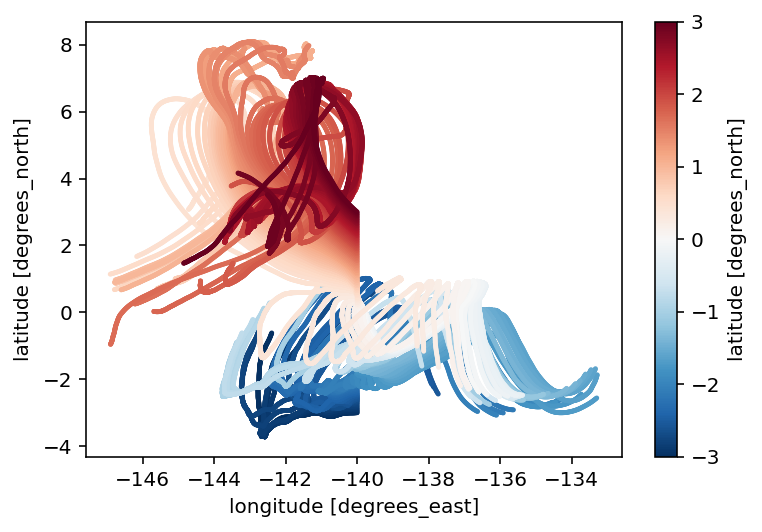

In [ ]:
traj.plot.scatter(x="lon", y="lat", hue="ilat", s=2)

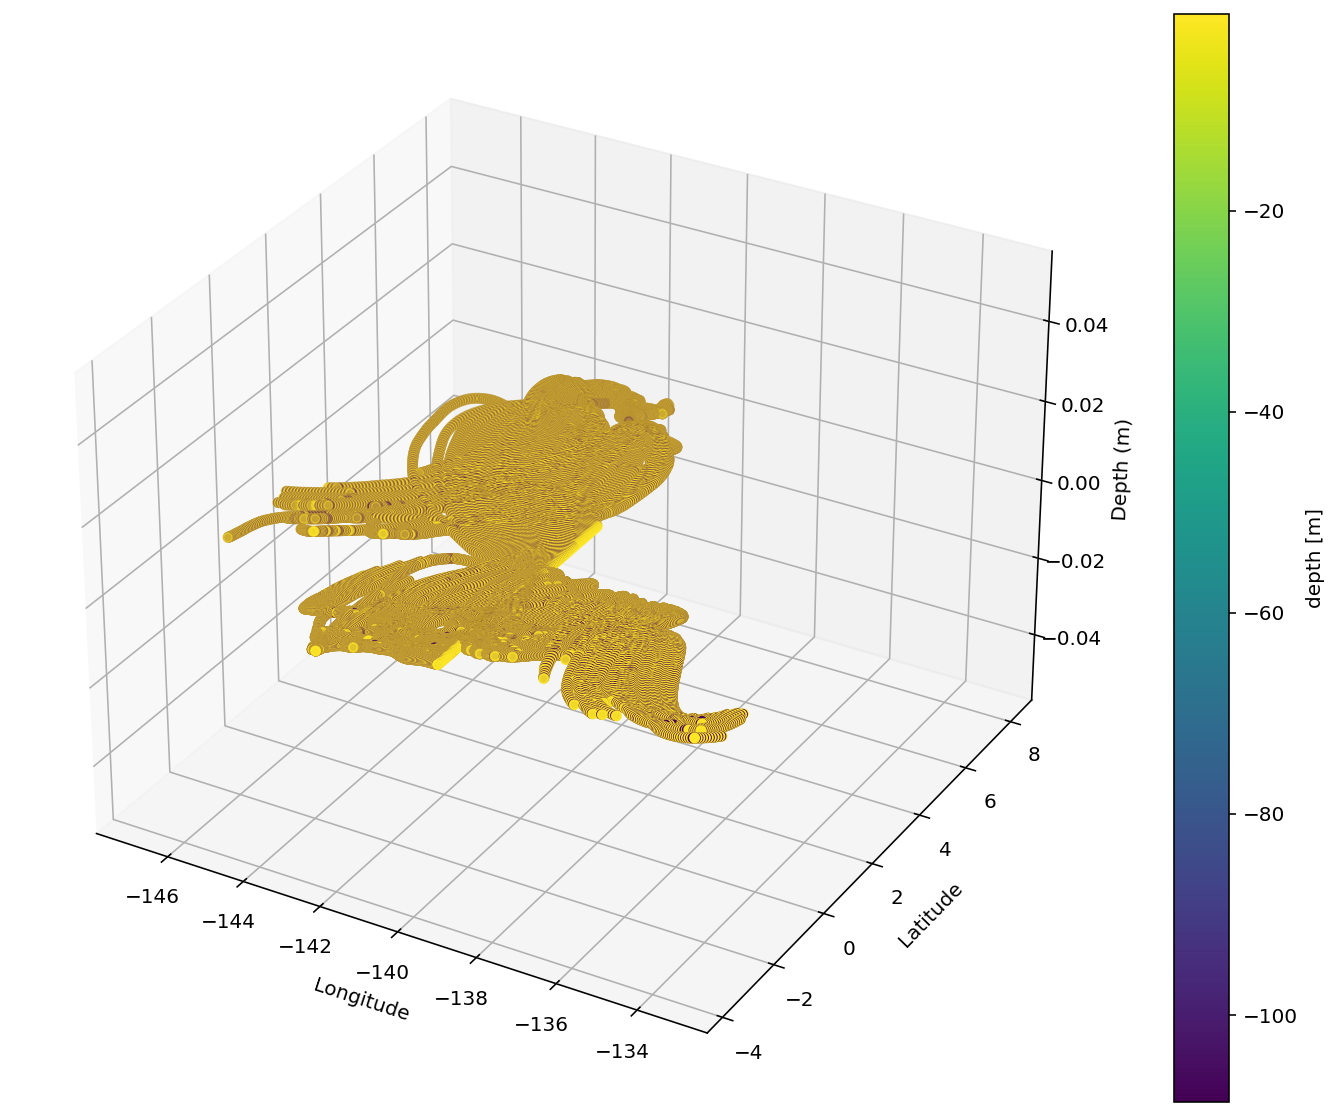

In [ ]:
traj = xr.open_dataset("../trajectories/emapex_float.nc").set_coords("time")
traj.coords["ilat"] = traj.lat.sel(obs=0)


fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = traj.plot.scatter(x="lon", y="lat", hue="z", s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
plt.show()

In [ ]:
# Define the new Kernel that mimics Argo vertical movement
def ArgoVerticalMovement(particle, fieldset, time):

    if all(fieldset.U.depth >= 0):
        sign = 1
    else:
        sign = -1

    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and xrise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += sign * vertical_speed * particle.dt
        print(particle.depth)
        if abs(particle.depth) >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle.depth += sign * vertical_speed * particle.dt
        if abs(particle.depth) >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle.depth -= sign * vertical_speed * particle.dt
        # particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]  # if fieldset has temperature
        if abs(particle.depth) <= fieldset.mindepth:
            particle.depth = sign * fieldset.mindepth
            # particle.temp = 0./0.  # reset temperature to NaN at end of sampling cycle
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    # if particle.state == ErrorCode.Evaluate:
    #    particle.cycle_age += particle.dt  # update cycle_age